# Import Required Libraries
Import necessary libraries for data manipulation such as pandas, numpy, and json.

In [ ]:
# Import Required Libraries
import pandas as pd
import numpy as np 
import json
from bao import *   # author self-developed library
from functions import * # author self-developed library

# <center> Load and Explore CIC Data
Load the CIC data from files and explore its structure to understand the nested format.

In [25]:
df = pd.read_excel('./1. Professional Test.xlsx', engine='calamine', sheet_name='Dataset')

##  <center> Check duplicates for id

In [26]:
id=['customer_id', 'disbursement_date']
df[id].drop_duplicates().shape
df.shape

(14000, 2)

(14000, 77)

In [27]:
df.set_index(id, inplace=True)
# Apply the parsing function to each row in the CIC_DATA column
parsed_data = []
for i, row in df.iterrows():
    json_str = row['CIC_DATA']
    out = parse_row_cic(json_str)
    parsed_data.append(out)
# Create the dataframe after processing all rows
cic_df = pd.DataFrame(parsed_data, index=df.index)

In [ ]:
# Apply the function to count unique search code values
cic_df = process_columns(cic_df,aggregrate_input,function_mapping)

df=df.merge(cic_df, how='left', left_index=True, right_index=True)

In [28]:
# parquet is better faster, but excel is more readable
df.to_excel('./full_data.xlsx', index=True)

In [8]:
for i in df.columns:
    try:
        df[i] = df[i].astype('float')
    except:
        continue

# Distribution Analysis of First Payment Default (FPD10+)

This section analyzes the distribution of First Payment Default after 10+ days (FPD10+), which is a key metric for loan performance. Understanding the distribution of FPD10+ helps assess default risk patterns in our dataset.

We'll examine:
- The overall distribution of FPD10+ values
- Convert this metric into a binary classification target (defaulted vs non-defaulted)
- Use this binary target for subsequent predictive modeling

The binary classification approach (defining defaults as FPD10+ > 0) allows us to build models that can effectively predict the likelihood of customer defaults.

<Figure size 1400x800 with 0 Axes>

<Axes: >

<Axes: xlabel='FPD10+', ylabel='Count'>

Text(0.5, 1.0, 'Distribution of First Payment Default (FPD10+)')

Text(0.5, 0, 'FPD10+ Value')

Text(0, 0.5, 'Frequency')

<Axes: >

<Axes: xlabel='FPD10+'>

Text(0.5, 1.0, 'Box Plot of FPD10+ Values')

Text(0.5, 0, 'FPD10+ Value')

FPD10+ Statistics:
Count: 14000
Mean: 1.74
Median: 0.00
Standard Deviation: 3.41
Min: 0.00
Max: 10.00

Default Rate (FPD10+ > 0): 33.69%


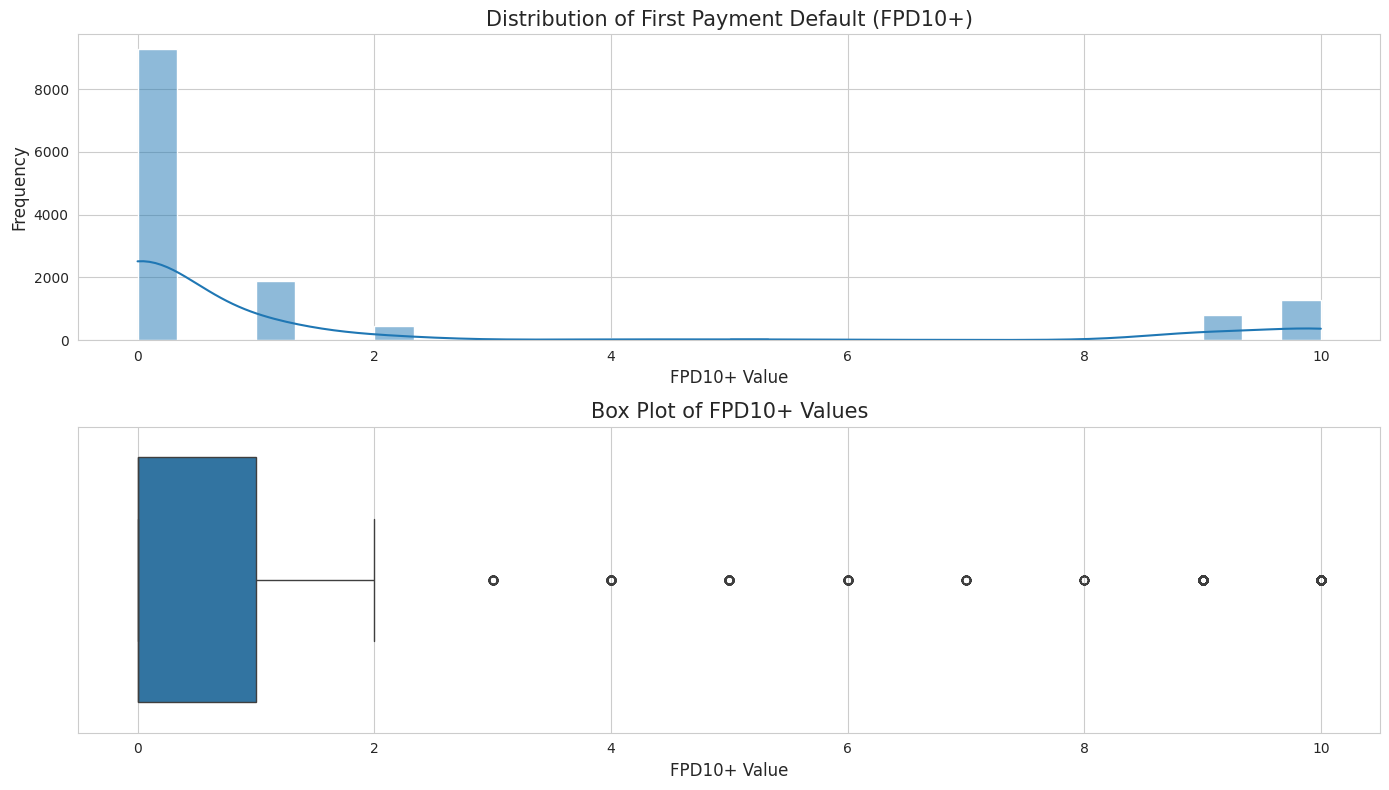

In [23]:
import seaborn as sns

import matplotlib.pyplot as plt

# Set figure size and style
plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")

# Create a layout with two plots
plt.subplot(2, 1, 1)
# Histogram with KDE
sns.histplot(df['FPD10+'], kde=True, bins=30)
plt.title('Distribution of First Payment Default (FPD10+)', fontsize=15)
plt.xlabel('FPD10+ Value', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.subplot(2, 1, 2)
# Box plot to show outliers
sns.boxplot(x=df['FPD10+'])
plt.title('Box Plot of FPD10+ Values', fontsize=15)
plt.xlabel('FPD10+ Value', fontsize=12)

plt.tight_layout()

# Display statistics about the distribution
print(f"FPD10+ Statistics:")
print(f"Count: {df['FPD10+'].count()}")
print(f"Mean: {df['FPD10+'].mean():.2f}")
print(f"Median: {df['FPD10+'].median():.2f}")
print(f"Standard Deviation: {df['FPD10+'].std():.2f}")
print(f"Min: {df['FPD10+'].min():.2f}")
print(f"Max: {df['FPD10+'].max():.2f}")
print(f"\nDefault Rate (FPD10+ > 0): {(df['FPD10+'] > 0).mean()*100:.2f}%")

> FPD10+ highly skew to the left, hence, it should be 0 FPD10+ would be classified non-default and other is default

In [9]:
# Create binary target for classification (1 if FPD10+ > 0, else 0)
df['binary_label'] = 0
df.loc[df['FPD10+'] > 0, 'binary_label'] = 1

# Check the distribution of the new binary label
print(df['binary_label'].value_counts())


binary_label
0    9283
1    4717
Name: count, dtype: int64


In [10]:
X_train, X_test, y_train, y_test = split_data(
    df,
    target_column='binary_label',  # Change this if your target column has a different name
    test_size=0.2,
    random_state=42,
    max_ratio=0.5,
    rebalance=False# Ensures no category exceeds 50% in either split
)

Original data distribution:
binary_label
0    0.663071
1    0.336929
Name: proportion, dtype: float64

Some categories exceed 50.0% in split, but rebalancing is disabled.

Final train set distribut ion:
binary_label
0    0.663036
1    0.336964
Name: proportion, dtype: float64

Final test set distribution:
binary_label
0    0.663214
1    0.336786
Name: proportion, dtype: float64

Note: Some categories exceed 50.0% in train or test set
Categories exceeding in train: [0]
Categories exceeding in test: [0]


In [12]:
list_features = df.drop(columns=['binary_label','FPD10+','DPD10_3MOB','gender']).columns.values
final_list,erorr_list=find_useful_feasture(list_features=list_features,
    X_train=X_train,
    y_train=y_train,
)
len(final_list)

Age
occupation
month_incom
address_apply
operating_system
phone_provider
CIC_DATA
SHORT_TERM_AMOUNT
MID_TERM_AMOUNT
LONG_TERM_AMOUNT
SHORT_TERM_COUNT
MID_TERM_COUNT
LONG_TERM_COUNT
SHORT_TERM_COUNT_BANK
MID_TERM_COUNT_BANK
LONG_TERM_COUNT_BANK
SHORT_TERM_COUNT_NON_BANK
MID_TERM_COUNT_NON_BANK
LONG_TERM_COUNT_NON_BANK
NUM_LOANS
NUM_LOANS_BANK
NUM_LOANS_NON_BANK
NUM_CC
NUM_CC_BANK
NUM_CC_NON_BANK
NUM_RELATIONSHIP
OUTS_BAL_LOAN_M1
OUTS_BAL_CC_M1
OUTS_BAL_ALL_M1
OUTS_BAL_LOAN_M2
OUTS_BAL_CC_M2
OUTS_BAL_ALL_M2
OUTS_BAL_LOAN_M3
OUTS_BAL_CC_M3
OUTS_BAL_ALL_M3
OUTS_BAL_LOAN_M4
OUTS_BAL_CC_M4
OUTS_BAL_ALL_M4
OUTS_BAL_LOAN_M5
OUTS_BAL_CC_M5
OUTS_BAL_ALL_M5
OUTS_BAL_LOAN_M6
OUTS_BAL_CC_M6
OUTS_BAL_ALL_M6
OUTS_BAL_LOAN_M7
OUTS_BAL_CC_M7
OUTS_BAL_ALL_M7
OUTS_BAL_LOAN_M8
OUTS_BAL_CC_M8
OUTS_BAL_ALL_M8
OUTS_BAL_LOAN_M9
OUTS_BAL_CC_M9
OUTS_BAL_ALL_M9
OUTS_BAL_LOAN_M10
OUTS_BAL_CC_M10
OUTS_BAL_ALL_M10
OUTS_BAL_LOAN_M11
OUTS_BAL_CC_M11
OUTS_BAL_ALL_M11
OUTS_BAL_LOAN_M12
OUTS_BAL_CC_M12
OUTS_BAL_ALL_M12


101

In [13]:
# For numeric features, handle missing values by filling with median
scorecard=Create_Score_Card(X_train,y_train,final_list)

Categorical variables for binning: []


> scorecard.xlsx will explain how features are transformed for score.

In [ ]:
scorecard.table(style='detailed').to_excel('./scorecard.xlsx', index=True)

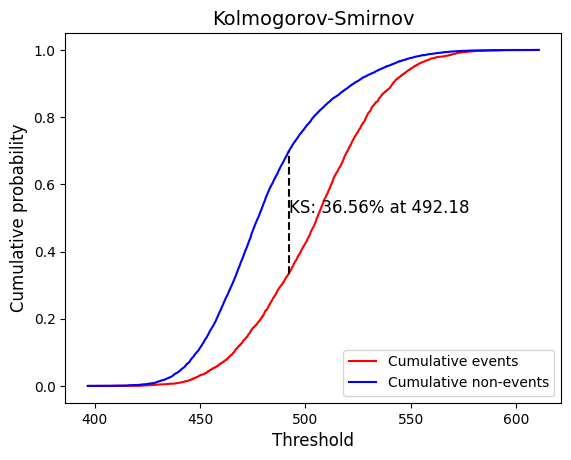

In [15]:
# Assign score and predicted probability to test dataset
X_train.loc[:,"score"] = scorecard.score(X_train)
# Kolmogorov_Smirnov Plot
plot_ks(y_train, X_train.score)


Gini Coefficient: 0.4405


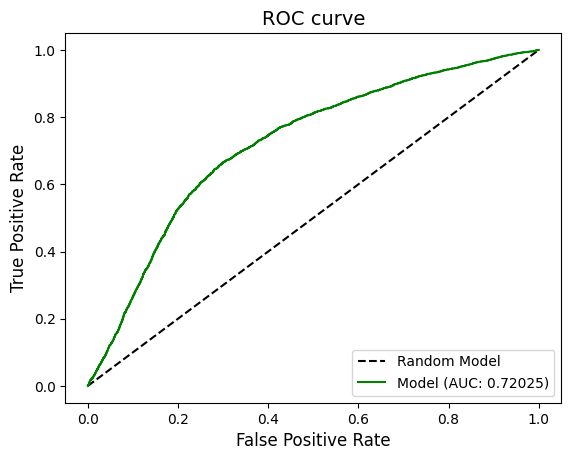

In [16]:
auc=plot_auc_roc(y_train, X_train.score)
gini=2 * auc - 1
print(f"Gini Coefficient: {gini:.4f}")

Gini Coefficient: 0.3520


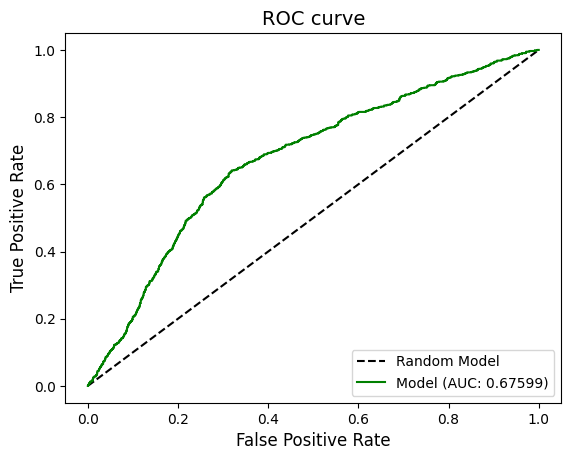

In [17]:
X_test.loc[:,"score"] = scorecard.score(X_test)
auc=plot_auc_roc(y_test, X_test.score)
gini=2 * auc - 1
print(f"Gini Coefficient: {gini:.4f}")

Population Stability Index (PSI) Results:
                          Feature       PSI         Interpretation
77   DUNO_THETD_HANMUC_THETD_mean  0.026455  No significant change
80  DUNO_THETD_SOTIEN_PHAI_TT_max  0.018580  No significant change
76    DUNO_THETD_HANMUC_THETD_max  0.018008  No significant change
75    DUNO_THETD_HANMUC_THETD_min  0.014792  No significant change
10                    NUM_CC_BANK  0.013120  No significant change
..                            ...       ...                    ...
67         DUNO_12THANG_THANG_min  0.000346  No significant change
68         DUNO_12THANG_THANG_max  0.000346  No significant change
1                     month_incom  0.000114  No significant change
92   DUNO_THETD_SOLUONG_THETD_max  0.000103  No significant change
56                       NGAYCHAM  0.000057  No significant change

[101 rows x 3 columns]

Summary: 101 stable features, 0 features with moderate change, 0 features with significant change


(<Figure size 1200x2500 with 1 Axes>,
 <Axes: title={'center': 'Population Stability Index (PSI) by Feature'}, xlabel='PSI Value', ylabel='Feature'>)

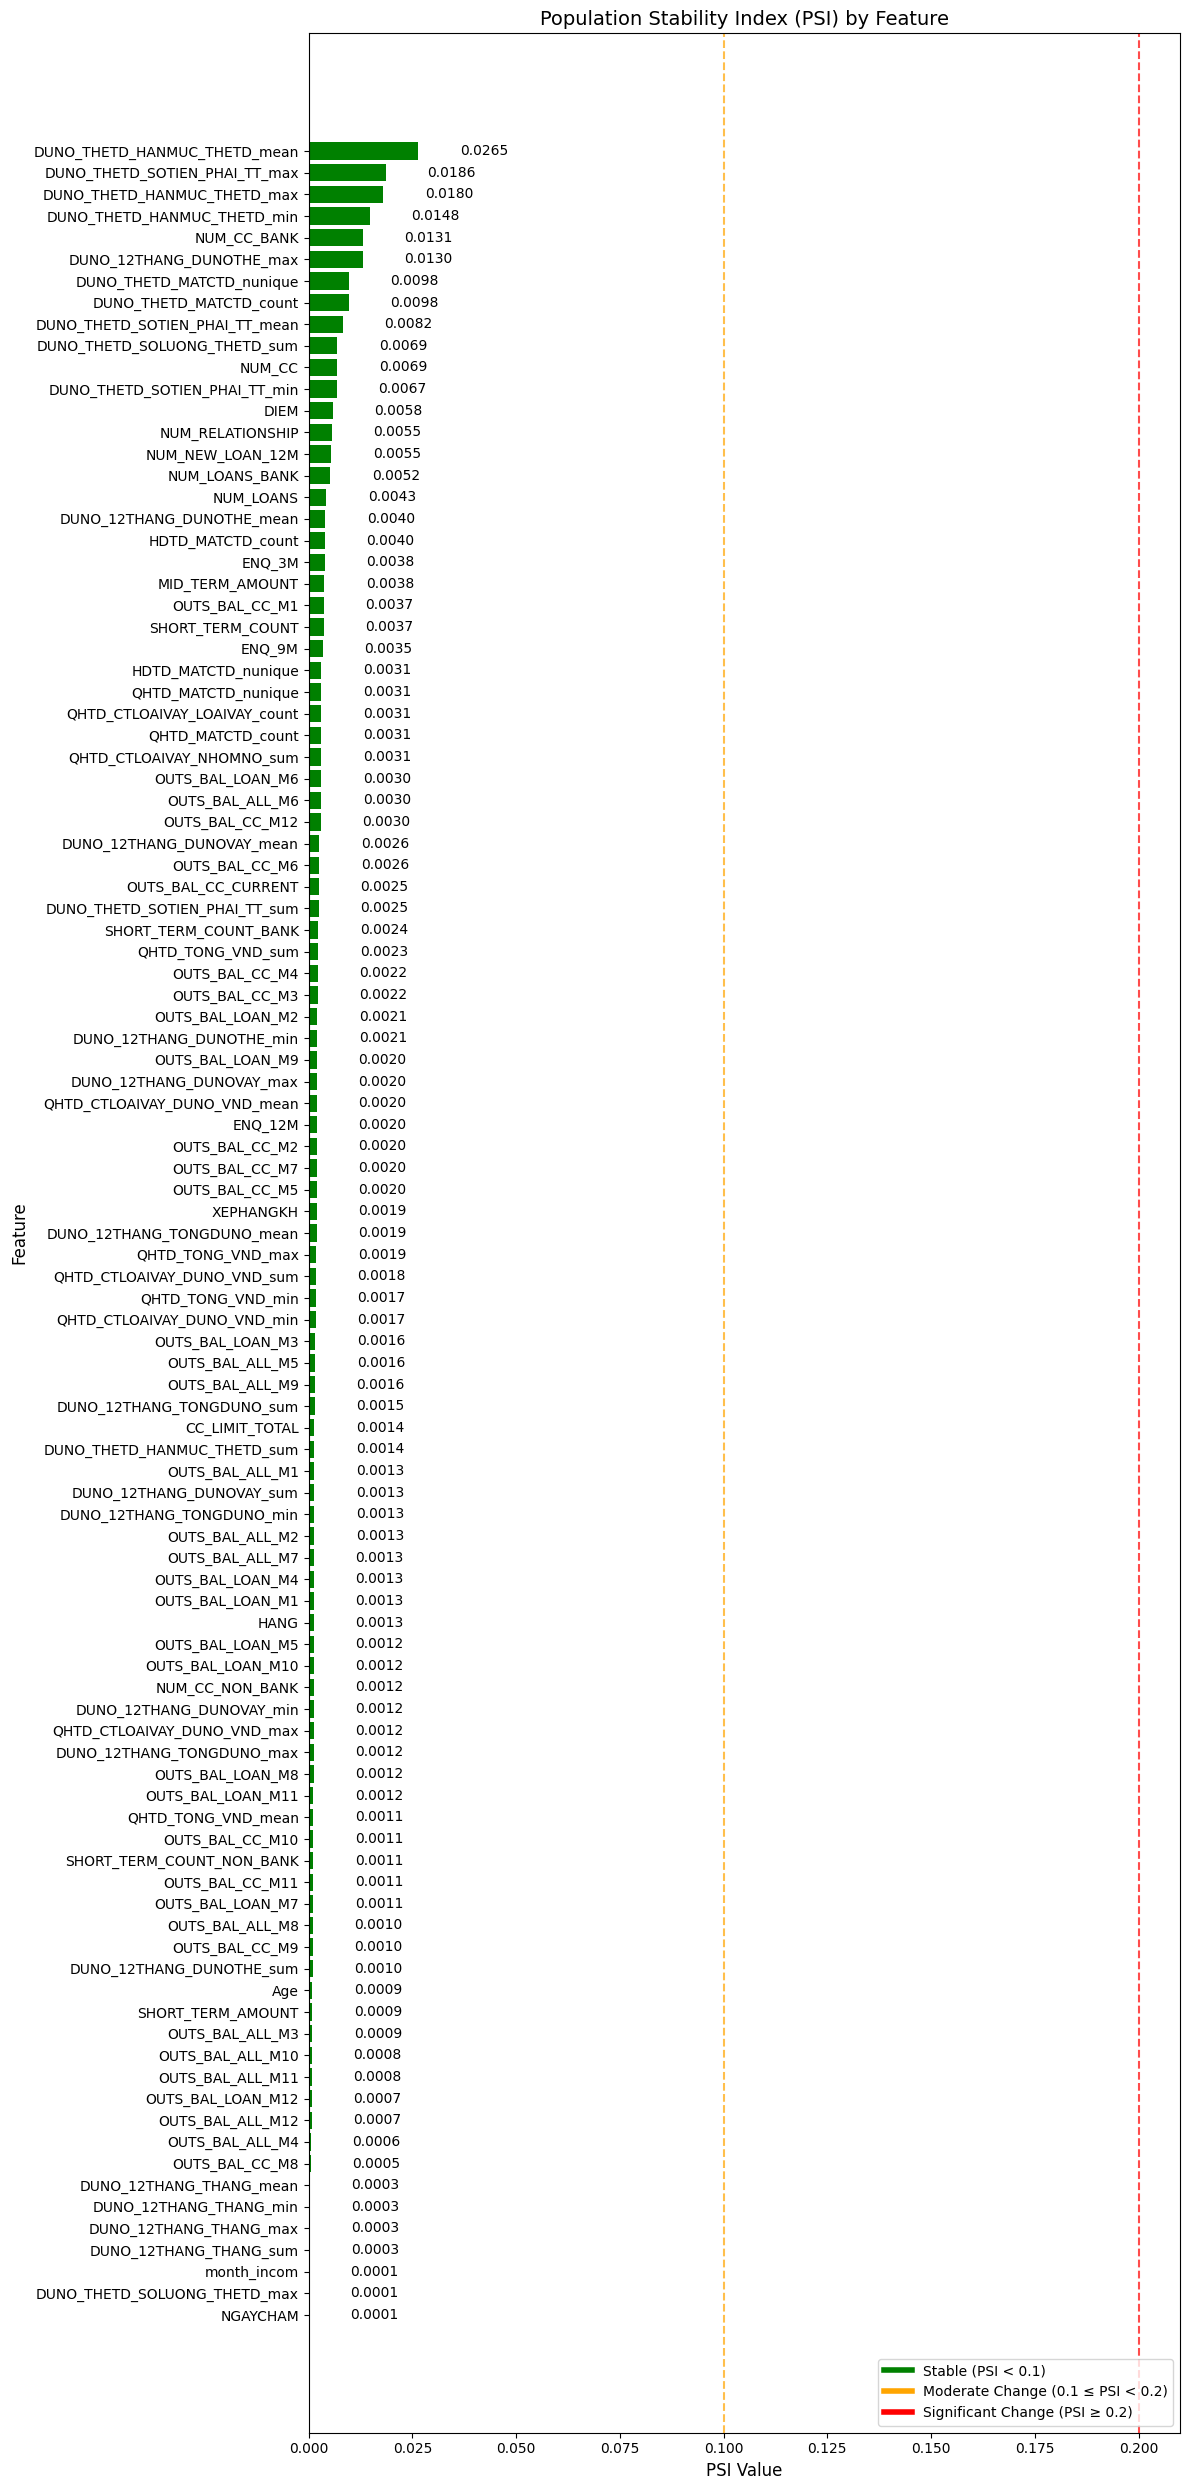

In [18]:
result_psi=calculate_psi(X_train,X_test,features_list=final_list)
plot_psi_distribution(result_psi,figsize=(12, 25))

In [29]:
X_train.to_excel('./train_data.xlsx', index=True)
X_test.to_excel('./test_data.xlsx', index=True)
y_train.to_excel('./train_label.xlsx', index=True)
y_test.to_excel('./test_label.xlsx', index=True)

In [19]:
full_data=pd.concat([X_train,X_test],axis=0)

In [20]:
full_data=pd.concat([full_data,pd.concat([y_test,y_train],axis=0)],axis=1)

> It can be seen that higher score group has higher probability to get labeled "default"



In [37]:
grouped=catering_score(full_data,'score','binary_label')
grouped

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 462.53)",2821,0.201500,2427,394,0.139667,1.141049,0.203013,0.024084
1,"[462.53, 480.24)",3226,0.230429,2575,651,0.201798,0.698083,0.097297,0.011921
2,"[480.24, 492.15)",2005,0.143214,1453,552,0.275312,0.290826,0.011487,0.001431
3,"[492.15, 504.58)",1660,0.118571,965,695,0.418675,-0.348796,0.015133,0.001882
4,"[504.58, inf)",4288,0.306286,1863,2425,0.565532,-0.940655,0.294809,0.035550
5,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
6,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,14000,1.000000,9283,4717,0.336929,,0.621740,0.074868


<Axes: xlabel='Bin', ylabel='Event rate'>

Text(0.5, 0, 'Score Bin')

Text(0, 0.5, 'Population Count')

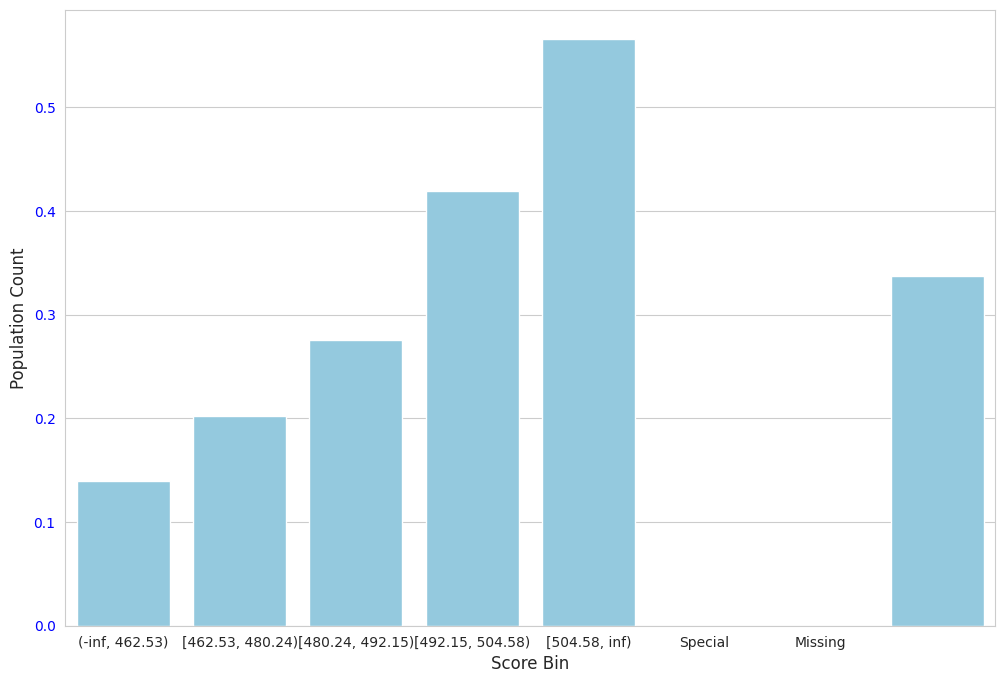

In [36]:
# Create a figure with dual y-axes
fig, ax1 = plt.subplots(figsize=(12, 8))
# Plot the bar chart for population count
sns.barplot(x='Bin', y='Event rate', data=grouped, color='skyblue', ax=ax1)
ax1.set_xlabel('Score Bin', fontsize=12)
ax1.set_ylabel('Population Count', fontsize=12)
ax1.tick_params(axis='y', labelcolor='blue')